In [1]:
!pip install -U scikit-learn pandas matplotlib tqdm torch torchvision torchaudio

Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-1.10.2-cp36-cp36m-manylinux1_x86_64.whl (881.9 MB)
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  # Sigmoid activation for output to ensure values are between 0 and 1
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
input_dim = 784
latent_dim = 20

vae = VAE(input_dim, latent_dim)
vae.to(device)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
  )
  (fc_mu): Linear(in_features=128, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

In [5]:
from IPython import display

import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Download MNIST dataset
X_mnist, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# Normalize data
X_mnist = X_mnist / 255.0

In [6]:
X = X_mnist[y == '1'].to_numpy()
X_tensor = torch.tensor(X, dtype=torch.float32)

batch_size = 128
train_loader = DataLoader(TensorDataset(X_tensor), batch_size=batch_size, shuffle=True)

In [7]:
import torch.optim as optim

optimizer = optim.Adam(vae.parameters(), lr=0.001)

def vae_loss(x_gen, x, mu, logvar):
    # Reconstruction loss
    gen_loss = F.binary_cross_entropy(x_gen, x.view(-1, input_dim), reduction='sum')
    
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return gen_loss + kl_loss

Epoch [1/10], Loss: 5689.0782 | 0.75s


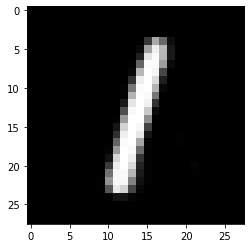

Epoch [2/10], Loss: 5676.1940 | 0.75s
Epoch [3/10], Loss: 5678.5058 | 0.74s
Epoch [4/10], Loss: 5695.0652 | 0.67s
Epoch [5/10], Loss: 5704.5542 | 0.69s
Epoch [6/10], Loss: 5698.1658 | 0.71s


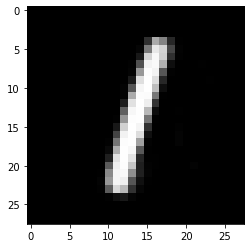

Epoch [7/10], Loss: 5685.2677 | 0.69s
Epoch [8/10], Loss: 5683.1424 | 0.69s
Epoch [9/10], Loss: 5675.5416 | 0.71s
Epoch [10/10], Loss: 5674.8422 | 0.70s


In [37]:
import time
from tqdm import tqdm

num_epochs = 10

for epoch in range(num_epochs):
    vae.train()
    total_loss = 0
    t0 = time.time()
    for data in train_loader:
        optimizer.zero_grad()
        x = data[0]
        
        x_gen, mu, logvar = vae(x)
        loss = vae_loss(x_gen, x, mu, logvar)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    t1 = time.time()
    # Print average loss for the epoch
    print('Epoch [{}/{}], Loss: {:.4f} | {:.2f}s'.format(
        epoch+1, 
        num_epochs, 
        total_loss / len(train_loader), 
        t1-t0
    ))
    if epoch % 5 == 0:
        r = torch.rand((latent_dim,))
        x_gen = vae.decode(random_point.reshape(1, -1))
        plt.imshow(x_gen.detach().numpy().reshape(28,28), cmap='gray')
        plt.show()

In [38]:
data_uniform = torch.rand((X.shape[0], latent_dim))
data_uniform.shape

torch.Size([7877, 20])

In [39]:
generated_images = []
with torch.no_grad():
    for i, random_point in enumerate(data_uniform):
        generated_images.append(vae.decode(random_point.reshape(1, -1)).reshape(-1))

In [40]:
X_gen = np.array([x.detach().cpu().numpy() for x in generated_images])
assert X_gen.shape == X.shape

In [41]:
X_knn = np.vstack([X, X_gen])
y_knn = np.array(X.shape[0]*[1] + X_gen.shape[0]*[0])

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X_knn, y_knn, test_size=0.3, random_state=42)

# Create kNN classifier. You can adjust the number of neighbors (n_neighbors)
knn = KNeighborsClassifier(n_neighbors=3)

# Train the classifier
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 93.97%


In [43]:
def plot_generated_images(generated_images):
    plt.figure(figsize=(10, 10))
    for i in range(10):
        for j in range(10):           
            plt.subplot(10, 10, i*10+j+1)
            plt.imshow(generated_images[i*10 + j].reshape(28,28), cmap='gray')
            plt.axis('off')
    plt.show()

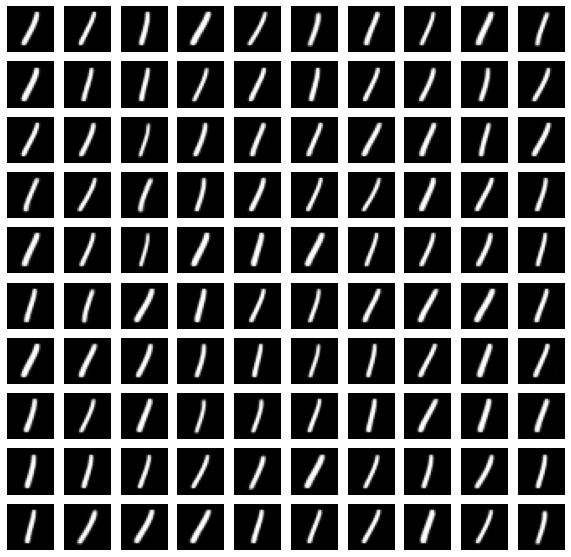

In [44]:
plot_generated_images(generated_images)